### Install

In [17]:
#pip install ucimlrepo

### Imports

In [18]:
# Imports
from ucimlrepo import fetch_ucirepo
import pandas as pd
import psycopg2
from collections import defaultdict
from scipy import stats as kl
from decimal import Decimal
import numpy as np
from scipy.stats import entropy, wasserstein_distance
from itertools import product
import matplotlib.pyplot as plt
from itertools import product


In [19]:
connection = psycopg2.connect(database="Project645", user="vaishnavishah", password="10jan2001", host="localhost", port=5432)
#connection = psycopg2.connect(database="Project645", user="postgres", password="Rajada1234@", host="localhost", port=5433)
#connection = psycopg2.connect(database="seedb", user="postgres", password="nineten910", host="localhost", port=5432)
cursor = connection.cursor()


In [20]:
# checking execution
query = "select workclass from married limit 5;"

cursor.execute(query)
record = cursor.fetchall()
print(record)

[('Self-emp-not-inc',), ('Private',), ('Private',), ('Private',), ('Private',)]


In [21]:
aggregation_functions = ['avg', 'sum', 'max', 'min', 'count']
group_by_columns = [
    'workclass',
    'education',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country',
]
measure_columns = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week'
]

In [22]:
# FORMULAS 

min_fl = np.finfo(float).eps
def kl_distance(target, reference):

    target = dict(target)
    reference = dict(reference)

    t = list()
    r = list()

    # we need this because this ensures that there are the same number of categories in each distribution
    for key in set().union(target.keys(), reference.keys()):
        t_val = float(target.get(key, 0))
        r_val = float(reference.get(key, 0))
        t.append(t_val)
        r.append(r_val)


    # normalize to create a probability distribution
    t = np.asarray(t) / (np.sum(t) or 1.0)
    r = np.asarray(r) / (np.sum(r) or 1.0)
    t = [max(x, min_fl) for x in t]
    r = [max(x, min_fl) for x in r]


    return entropy(t, r)

def hoeffding_serfling_interval(phase, num_phases, delta):
    phase = float(phase)
    num_phases = float(phase)
    numerator = (1 - ((phase - 1) / num_phases)) * (2 * np.log(np.log(phase)) + np.log((np.pi * np.pi) / (3 * delta)))
    epsilon_m = np.sqrt(numerator / (2 * phase))
    return epsilon_m

In [23]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country

In [24]:
def naive_search(cur, views_ls, top_k=5, verbose=False):

    grouped_views = defaultdict(list)

    for view in views_ls:
        grouper = view[0]
        grouped_views[grouper].append(view)

    query = "select {group}, {func}({m_col}) from {table} {where} group by {group};"

    results = list()
    for group, views in grouped_views.items():
        for view in views:
            _, func, m_col = view
            target_query = query.format(group=group,
                                        func=func,
                                        m_col=m_col,
                                        table='married',
                                        )

            cur.execute(target_query)
            target_results = cur.fetchall()

            reference_query = query.format(group=group,
                                           func=func,
                                           m_col=m_col,
                                           table='unmarried',
                                           )
            cur.execute(reference_query)
            reference_results = cur.fetchall()

            dist = kl_distance(target_results, reference_results)
            results.append((view, dist))

            if verbose:
                print ("{}, {}, {}".format(group, func, m_col), dist)

    return list(reversed(sorted(results, key=lambda x: x[1])))[:top_k]


In [25]:
def sharing_based_search(cur, views_ls, top_k=5, verbose=False):
    
    query_template = "select {group} {aggregated_measures} from {table} {where} group by {group};"

    results = []
    grouped_views = defaultdict(list)

    for view in views_ls:
        grouper = view[0]
        grouped_views[grouper].append(view)

    for group, pairs in grouped_views.items():

        aggregated_measures = "".join(", {func}({col})".format(func=func, col=col) for _, func, col in pairs)
        target_query = query_template.format(group=group,
                                    aggregated_measures=aggregated_measures,
                                    table='married',
                                    where=""
                                    )
        cur.execute(target_query)
        t_v = cur.fetchall()

        reference_query = query_template.format(group=group,
                                       aggregated_measures=aggregated_measures,
                                       table='unmarried',
                                       where="")
        cur.execute(reference_query)
        r_v = cur.fetchall()

        for i, view in enumerate(pairs):
            target_results = [(v[0], v[i+1]) for v in t_v]
            reference_results = [(v[0], v[i+1]) for v in r_v]

            dist = kl_distance(target_results, reference_results)
            if verbose:
                print( view, dist)
            results.append((view, dist))

    return list(reversed(sorted(results, key=lambda x: x[1])))[:top_k]

In [26]:
def pruning_based_search(cur, views, top_k=5, verbose=False):
    mean_utils = {}

    for view, utility in sharing_based_search(cur, views, top_k=None):
        mean_utils[view] = (mean_utils.get(view, 0) + utility) / 2

    sorted_utils = sorted(mean_utils.values())
    max_utility = sorted_utils[-1]
    kth_utility = sorted_utils[-top_k] / max_utility

    for i in range(len(views)):
        if i == 0:
            if verbose:
                print("No pruning on the first iteration due to NaN epsilon.")
            continue

        epsilon = hoeffding_serfling_interval(i + 1, len(views), 0.1) 

        not_pruned_views = [v for v in views if (mean_utils[v] / max_utility + epsilon) >= (kth_utility - epsilon)]

        if verbose:
            print("Iteration %d: Pruned %d views." % (i, len(views) - len(not_pruned_views)))

        views = not_pruned_views[:]

    if verbose:
        print("Finished with %d views." % len(views))

    return sharing_based_search(cur, views, top_k=top_k)


('relationship', 'sum', 'capital_gain') 35.15956612486812


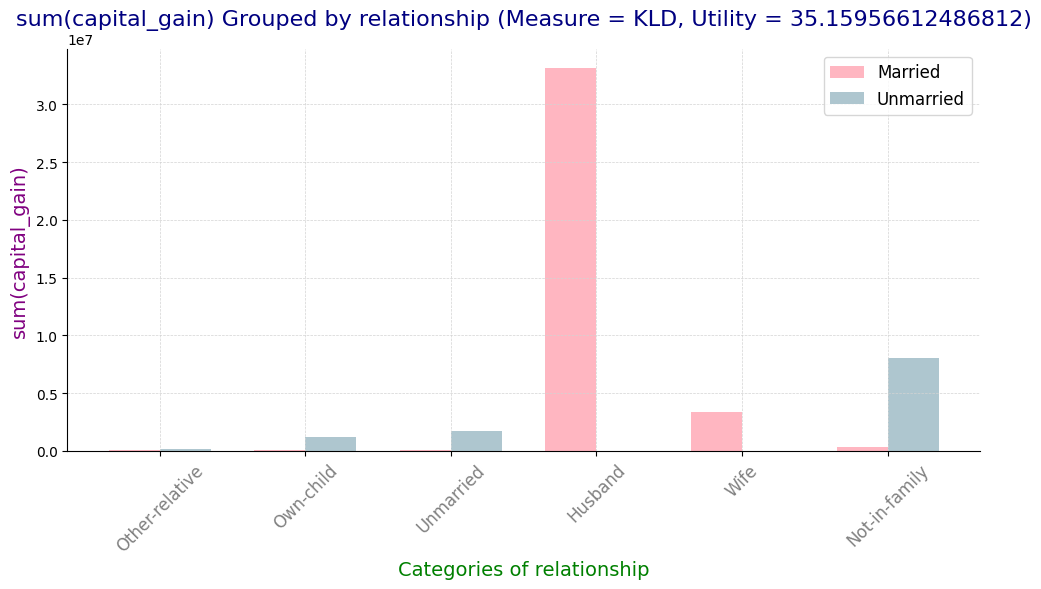

('relationship', 'sum', 'capital_loss') 34.877476735122976


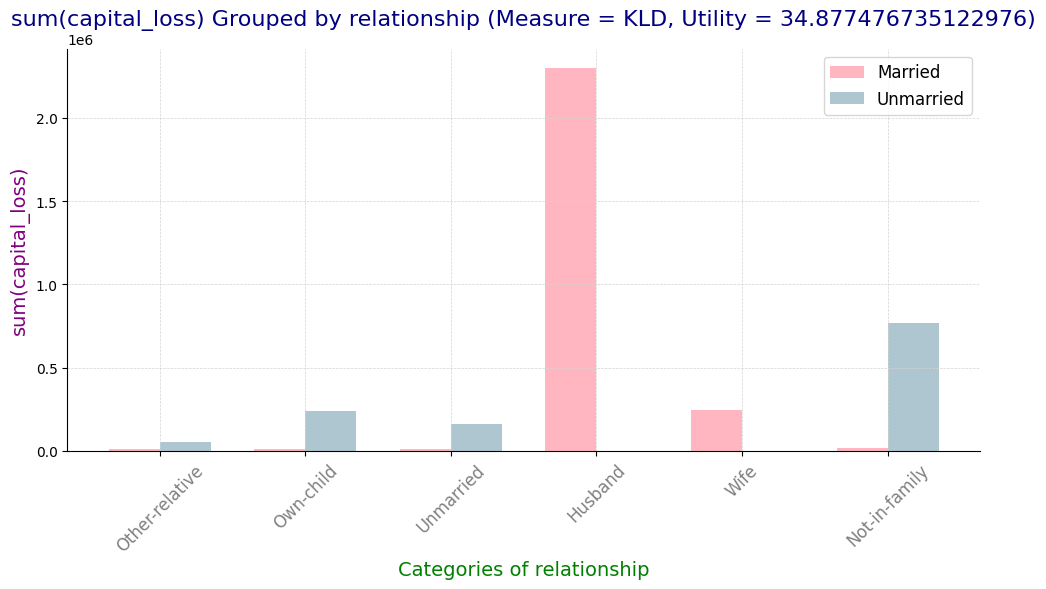

('relationship', 'sum', 'age') 34.29606419439562


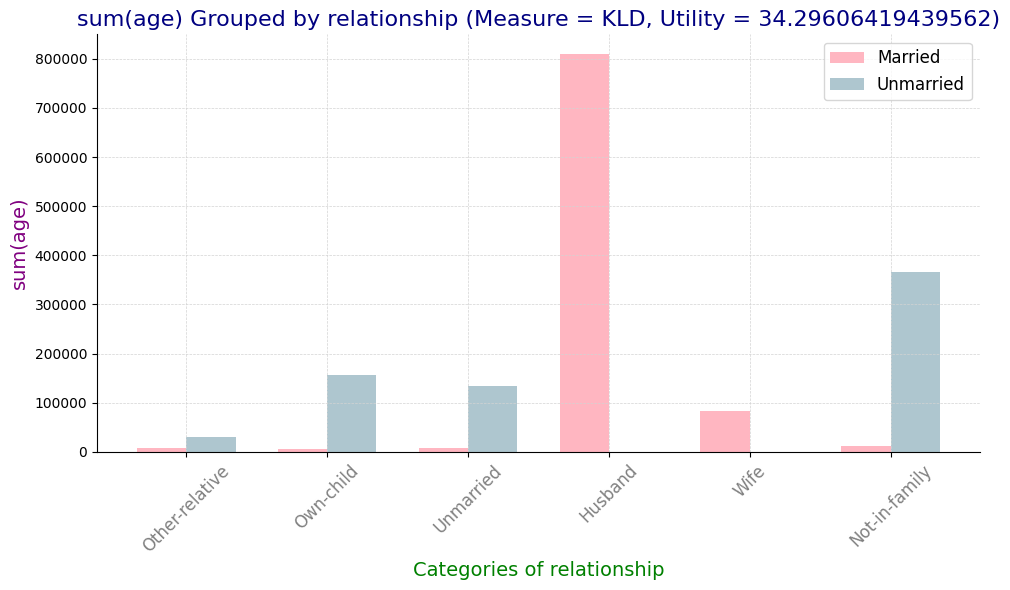

('relationship', 'sum', 'hours_per_week') 34.276281101060064


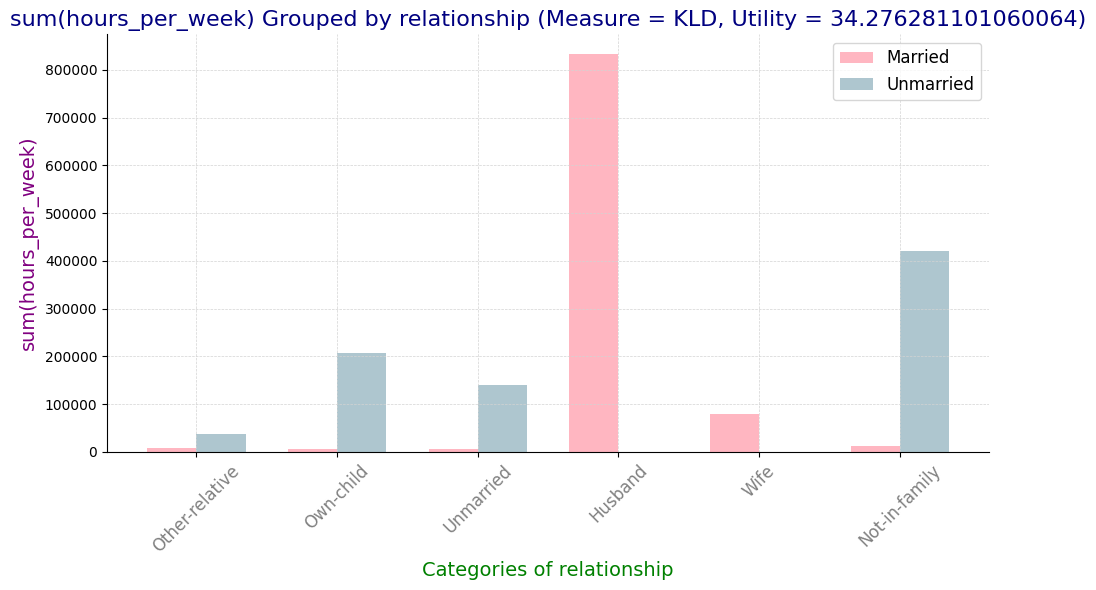

('relationship', 'sum', 'education_num') 34.26413048422267


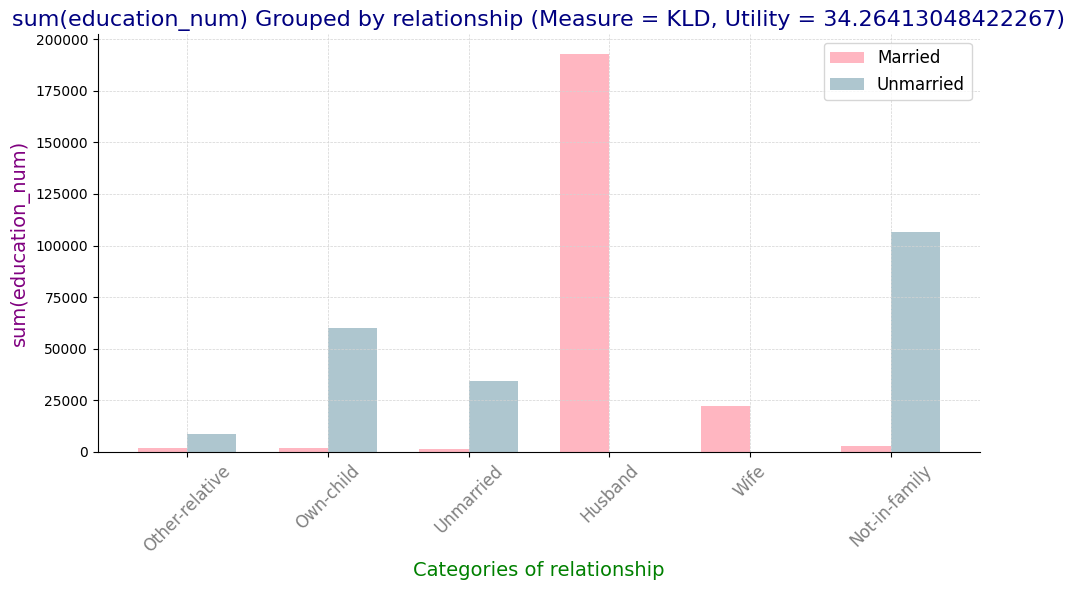

In [27]:
if __name__ == "__main__":

   
    views_ls = []
    for a in group_by_columns:
        for f in aggregation_functions:
            for m in measure_columns:
                views_ls.append((a,f,m))


    for i in range(1):
        #top_5 = pruning_based_search(cursor, init_list,verbose=True)

        top_5 = sharing_based_search(cursor, views_ls, verbose=False)

    for view, utility in top_5:
        print (view, utility)

        cursor.execute("select {g}, {f}({m}) from married group by {g};".format(g=view[0], f=view[1], m=view[2]))
        target = dict(cursor.fetchall())

        cursor.execute("select {g}, {f}({m}) from unmarried group by {g};".format(g=view[0], f=view[1], m=view[2]))
        reference = dict(cursor.fetchall())

        t = list()
        r = list()
        names = list()

        for key in set().union(target.keys(), reference.keys()):
            names.append(key)
            t_val = float(target.get(key, 0))
            r_val = float(reference.get(key, 0))
            t.append(t_val)
            r.append(r_val)
        
        width=0.35
        index = np.arange(len(names))

        fig, ax = plt.subplots(figsize=(10, 6)) 
        
        light_pink = '#FFB6C1'  
        pastel_blue = '#AEC6CF' 

        t_bar = ax.bar(index, t, width, color=light_pink)
        r_bar = ax.bar(index + width, r, width, color=pastel_blue)
        
        ax.set_title("{f}({m}) Grouped by {g} (Measure = {measure}, Utility = {util})".format(f=view[1],
        m=view[2],
        g=view[0],
        measure="KLD",
        util=utility),
        fontsize=16, color='navy')  
        ax.set_ylabel("{f}({m})".format(f=view[1], m=view[2]), fontsize=14, color='purple')  
        ax.set_xlabel("Categories of {g}".format(g=view[0]), fontsize=14, color='green') 
        ax.set_xticks(index + width / 2)
        ax.set_xticklabels(names, fontsize=12, color='gray', rotation=45)  

        ax.legend((t_bar[0], r_bar[0]), ('Married', 'Unmarried'), loc='upper right', fontsize=12)

        ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')  

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()  
        plt.show()

    connection.commit() 

In [28]:
cursor.close()
connection.close()

In [29]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country